# rtPB Data

Overview & exploration of the rtPB dataset.

In [1]:
%matplotlib inline

import os
import warnings
from pathlib import Path

import scipy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import pearsonr

import mne

from fooof import FOOOF, FOOOFGroup
from fooof.analysis.periodic import get_band_peak

/var/folders/59/8y2d5r257c77vzymnqs47x080000gn/T/ipykernel_55968/2285608827.py:15: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF, FOOOFGroup


## Settings

In [2]:
# Set data path
base_path = Path('/Volumes/Data/01-Internal/rtPB/rtPB-3/processed/EEG/')

In [3]:
# These should stay the same
subj_fname = '3501_resampled.set'

In [4]:
# Define full path
full_path = base_path / subj_fname

In [5]:
# Check file path exists
assert os.path.exists(full_path)

### Load Data

In [6]:
# Read in subject listed above
eeg = mne.io.read_raw_eeglab(full_path, preload=True)

Reading /Volumes/Data/01-Internal/rtPB/rtPB-3/processed/EEG/3501_resampled.fdt
Reading 0 ... 1816662  =      0.000 ...  3633.324 secs...


/var/folders/59/8y2d5r257c77vzymnqs47x080000gn/T/ipykernel_55968/3184373795.py:2: RuntimeWarning: Data file name in EEG.data (3051_resampled.fdt) is incorrect, the file name must have changed on disk, using the correct file name (3501_resampled.fdt).
  eeg = mne.io.read_raw_eeglab(full_path, preload=True)


### Reference

In [7]:
# Set EEG average reference
eeg.set_eeg_reference()

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawEEGLAB | 3501_resampled.fdt, 64 x 1816663 (3633.3 s), ~887.1 MB, data loaded>

### Montage Information

In [8]:
# Create 1020 montage
montage = mne.channels.make_standard_montage('standard_1020')

In [9]:
# Add montage to EEG 
eeg = eeg.set_montage(montage)

### Marking bad channels

Based on visualization.

In [10]:
#eeg.info['bads'] = ['TP9']

In [11]:
print('Bad channels: ', eeg.info['bads'])

Bad channels:  []


In [12]:
#eeg.interpolate_bads()

## Events Management

In [13]:
# Get events from annotations
events, event_id = mne.events_from_annotations(eeg, verbose=False)

In [14]:
# Check event IDs
event_id

{'DECIMAL pressed': 1,
 'DECIMAL released': 2,
 'End Block': 3,
 'End Labelling Block': 4,
 'EndRest': 5,
 'Fall_Pres_catch': 6,
 'Fall_Pres_filt': 7,
 'Fall_Pres_thresh': 8,
 'Filt Labelling': 9,
 'HitTrial': 10,
 'Label_Fall_filt': 11,
 'Label_Fall_thresh': 12,
 'Label_Peak_filt': 13,
 'Label_Peak_thresh': 14,
 'Label_Rise_filt': 15,
 'Label_Rise_thresh': 16,
 'Label_Trough_filt': 17,
 'Label_Trough_thresh': 18,
 'Label_Undetected_thresh': 19,
 'Markers0': 20,
 'Markers0.0': 21,
 'Markers1': 22,
 'Markers1.0': 23,
 'MissTrial': 24,
 'NUMPAD0 pressed': 25,
 'NUMPAD0 released': 26,
 'NUMPAD1 pressed': 27,
 'NUMPAD1 released': 28,
 'NUMPAD3 pressed': 29,
 'NUMPAD3 released': 30,
 'NUMPAD5 pressed': 31,
 'NUMPAD5 released': 32,
 'Peak_Pres_catch': 33,
 'Peak_Pres_filt': 34,
 'Peak_Pres_thresh': 35,
 'Rise_Pres_catch': 36,
 'Rise_Pres_filt': 37,
 'Rise_Pres_thresh': 38,
 'SPACE pressed': 39,
 'SPACE released': 40,
 'Sham_Pres_catch': 41,
 'Sham_Pres_sham': 42,
 'Sham_Pres_threshold': 43,


### Check Events Structure

In [15]:
# Define events to plot
events_plot = {
    'StartRest' : event_id['StartRest'],
    'Start Labelling Block' : event_id['Start Labelling Block'],
    'Start Block' : event_id['Start Block'],
}
color = {
    event_id['StartRest'] : 'red',
    event_id['Start Labelling Block'] : 'green',
    event_id['Start Block'] : 'blue',
}

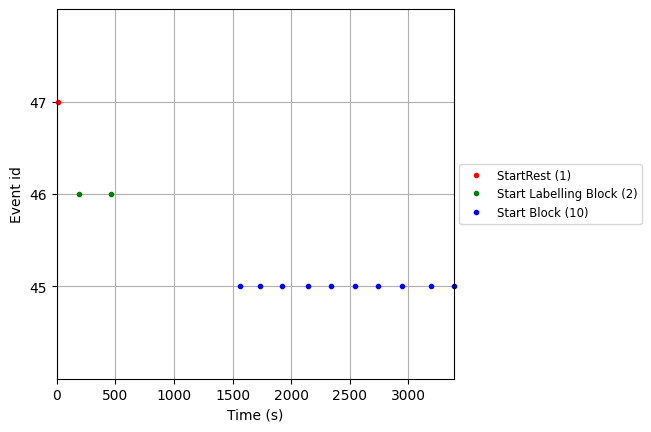

In [16]:
# Plot the events to get an idea of the paradigm - plotting only rest, label, and task block events
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    mne.viz.plot_events(events, eeg.info['sfreq'], eeg.first_samp,
                        color=color, event_id=events_plot)

In [17]:
# Check duration of rest event
rest_st_ind = events[events[:, 2] == event_id['StartRest']][0][0]
rest_en_ind = events[events[:, 2] == event_id['EndRest']][0][0]

In [18]:
# Check rest duration (in seconds)
(rest_en_ind - rest_st_ind) / eeg.info['sfreq']

119.988

### Epoching

In [19]:
# Define block events of interest
rest_events = {'StartRest' : event_id['StartRest']}
label_events = {'Start Labelling Block' : event_id['Start Labelling Block']}
task_blocks = {'Start Block' : event_id['Start Block']}

In [20]:
# Extract rest blocks, taking a ~2 minute time window
rest_epochs = mne.Epochs(eeg, events=events, event_id=rest_events,
                         tmin=5, tmax=115, baseline=None, preload=True)

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 55001 original time points ...
0 bad epochs dropped


In [21]:
# Extract experiment blocks, taking a ~2 minute time window
exp_blocks = mne.Epochs(eeg, events=events, event_id=task_blocks, 
                        tmin=5, tmax=115, baseline=None, preload=True)

Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10 events and 55001 original time points ...
0 bad epochs dropped


### Visualizing Data

Using matplotlib as 2D backend.


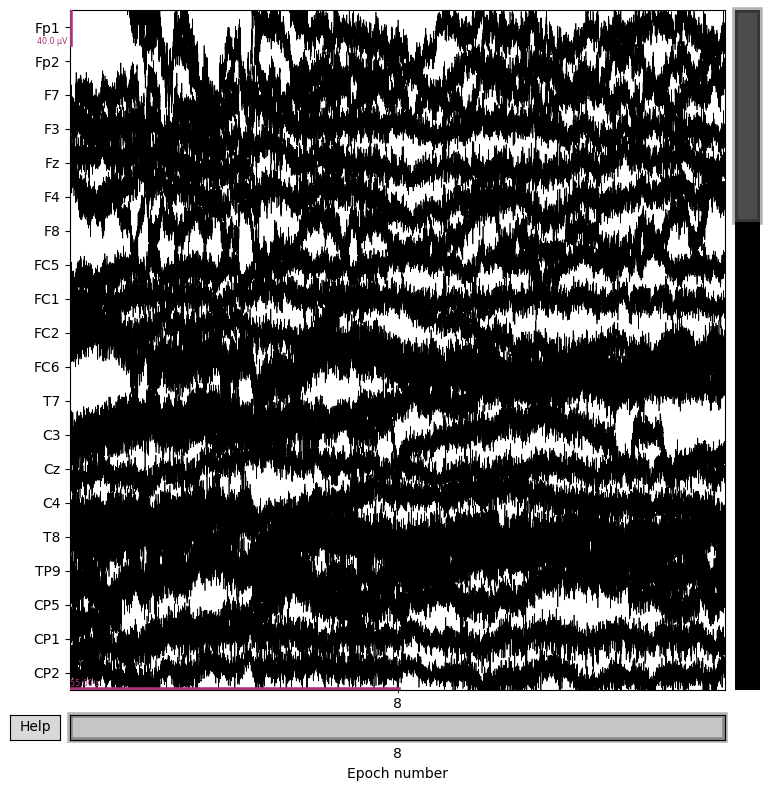

In [22]:
rest_epochs.plot();

# Marking bad moments

Identifying bad moments based on visualization

Note: not too critical for this data.

#### Drop Bad Epochs

In [23]:
# epochs.drop_bad()

## Analysis Checks

#### Calculate Power Spectra

In [24]:
# Calculate PSDs
spectrum = rest_epochs.compute_psd('welch', fmin=1., fmax=50., n_fft=2000, n_overlap=250, n_per_seg=500)

Effective window size : 4.000 (s)


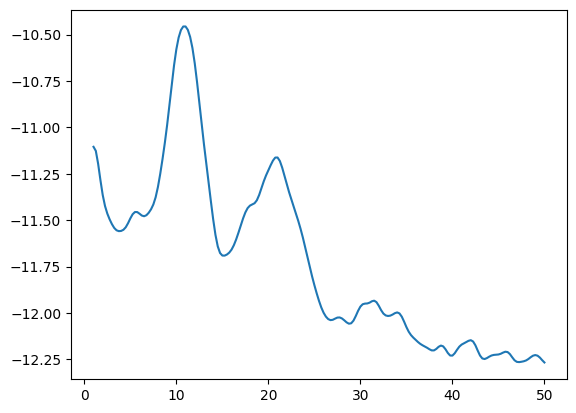

In [25]:
# Visualize an example power spectrum
plt.plot(spectrum.freqs, np.log10(spectrum._data[0, 30, :]))

# FOOOFing Data

In [26]:
fooof_psd = np.squeeze(spectrum._data[0, :, :])

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 32 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -10.6827, 1.2794                                         
                                                                                                  
                                       4 peaks were found:                                        
          

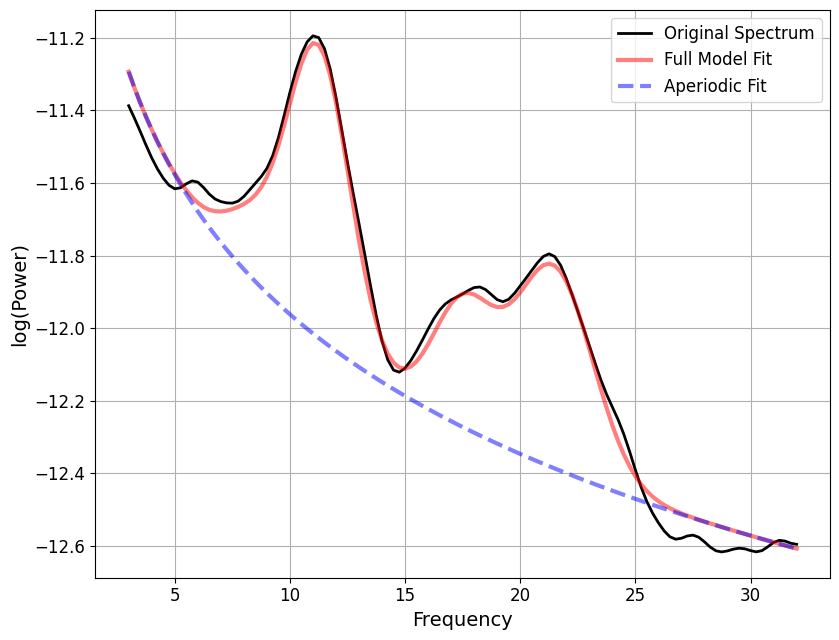

In [27]:
# Initialzing FOOOF model
fm = FOOOF(peak_width_limits=[1, 6], min_peak_height=0.075, max_n_peaks=6, peak_threshold=1)

# Setting frequency range
freq_range = [3, 32]

fm.report(spectrum.freqs, fooof_psd[40, :], freq_range)

In [28]:
# Run FOOOF across a group of PSDs
fg = FOOOFGroup(verbose=False)
fg.fit(spectrum.freqs, fooof_psd, freq_range)

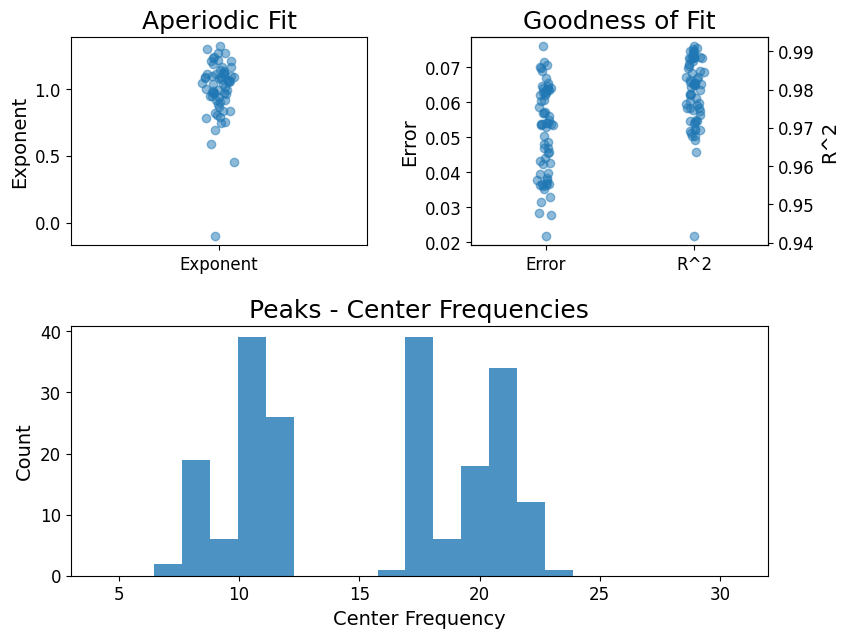

In [29]:
fg.plot()

In [30]:
n_channels, n_freq = fooof_psd.shape

In [31]:
fooof_results = np.zeros(shape = [n_channels, 3])
for ind, ch_dat in enumerate(fg.group_results):
    fooof_results[ind, :] = get_band_peak(ch_dat.peak_params, [8, 12])

In [32]:
cfs = np.nan_to_num(fooof_results[:, 0])
pws = np.nan_to_num(fooof_results[:, 1])
bws = np.nan_to_num(fooof_results[:, 2])

# Mapping

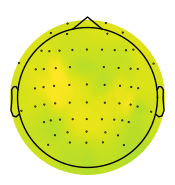

(<matplotlib.image.AxesImage at 0x7f866756f7c0>, None)

In [33]:
mne.viz.plot_topomap(cfs, rest_epochs.info, cmap=cm.viridis, contours=0, size=2)

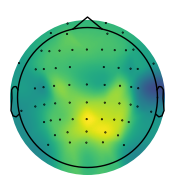

(<matplotlib.image.AxesImage at 0x7f866988d250>, None)

In [34]:
mne.viz.plot_topomap(pws, rest_epochs.info, cmap=cm.viridis, contours=0, size=2)

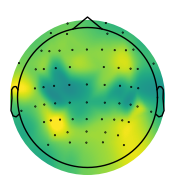

(<matplotlib.image.AxesImage at 0x7f86698e0280>, None)

In [35]:
mne.viz.plot_topomap(bws, rest_epochs.info, cmap=cm.viridis, contours=0, size=2)